# Dataset : Pierres, Feuilles, ciseaux
# Taille : 202 images RGB
# Classifieur : probleme de classification supervisee, k = 3 classes
# Famille de methodes : deep learning, computer vision

In [ ]:
# Version = 21, prise en compte des remarques de notre enseignant Pierre Boudier

In [1]:
# =========================================================================
# Date : 26 nov. 2018
# MS Valdom > apprenants > omar attaf, laurent lapasset, didier le picaut
# =========================================================================

In [2]:
#************************************************************************************#

In [3]:
#- CORRIGE : le flipping des images en x/y donne un facteur 2x2.
# Mais on a <1000 images alors que mnist est de l'ordre de 50 000.
# il faut essayer d'autres techniques (
 #-- changement de contraste, 
 #-- random noise, 
 #-- random squeeze, 
 #-- random rotate, ...)

In [4]:
# CORRIGE - l'accuracy est de 23% (moins bon que 33% si on classe au hasard); 
# CORRIGE - le commentaire sur le 1-accuracy est donc incorrect.

In [5]:
#- CORRIGE le print() de 30

In [6]:
# CORRIGE - batch_size est incorrect (30) ?

In [7]:
# CORRIGE - le batch size pour la version CPU semble trop grand (64)

In [8]:
#************************************************************************************#

In [10]:
#== importation des libraries necessaires pour la mise en oeuvre code Pytorch

import numpy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim
import torchvision

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
import matplotlib.pyplot as plt
import time

In [11]:
#== sanity check : library cuda est-elle presente ?
torch.cuda.is_available()

True

In [12]:
#== sanity check : presence du framework cudnn ?
torch.backends.cudnn.enabled

True

In [13]:
#== mise en place d un compteur de temps pour voir le temps de convergence du Rx neurones [trop  ou pas ?]
# Debut du decompte du temps
start_time = time.time()

In [14]:
#== generateur, pour reproductibilite du modele

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

In [15]:
#== analyse : apres plusieurs iterations de notre notebook, on a fait de la data augmentation horizontale et
#== verticale pour gagner plusieurs points d accuracy
#== pour les Rx de neurones, il faut beaucoup de donnees pour entrainer les parametres du classifieur

In [16]:
# normalize will center around -1 1

# ont ete teste les data augmentations :
 #-- changement de contraste, 
 #-- random noise, 
 #-- random squeeze, 
 #-- random rotate, ...)

#== Data augmentation retenues
trans = transforms.Compose([ 
                            transforms.Resize((32,32)),
                            transforms.Grayscale(),
                            
                            transforms.RandomRotation(45),
                            
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomVerticalFlip(p=0.5),
                        
                            transforms.ToTensor()
                            ])

In [17]:
# =========================================================================
# Application des transforms sur les datasets train and test
# =========================================================================

train = torchvision.datasets.ImageFolder('/home/lepic/N7/pytorch_TP/S2/train', trans)
test = torchvision.datasets.ImageFolder('/home/lepic/N7/pytorch_TP/S2/test', trans)
print (train.classes)
print (test.classes)

['paper', 'rock', 'scissors']
['paper', 'rock', 'scissors']


In [18]:
#== Poids train (%) = 74,25

In [19]:
#== sanity check longeur dataset train
longueurTrain=len(train)
longueurTrain

150

In [20]:
#== Poids test (%) = 25,75

In [21]:
#== sanity check longeur dataset test
longueurTest=len(test)
longueurTest

52

In [22]:
# Create DataLoader

dataloader_args = dict(shuffle=True, batch_size=len(train),num_workers=11, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)

dataloader_args = dict(shuffle=True, batch_size=len(test),num_workers=11, pin_memory=True)
test_loader = dataloader.DataLoader(test, **dataloader_args)


In [23]:
#== architecture du reseaux fully connected : Multi Layers Perceptron (a 3 couches) + 1 sortie softmax

In [24]:

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(32*32, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)
        
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.softmax(x,dim=1)
    
model = Model()
if cuda:
    model.cuda()

#== SGD pour passer le flow de calcul gradient dans GPU GTX1060M
#== travail d optimisation du learning rate - test du vecteur valeur (0.1, 0.01, 0.001) 
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [25]:
EPOCHS = 5
losses = []

# Eval
evaluate_x, evaluate_y = iter(test_loader).next()
evaluate_x = evaluate_x.unsqueeze_(1)

if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()
train_size = len(train_loader.dataset)

batch_size = (train_size / 256) if (cuda) else  (train_size / 64)


model.train()

for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # Get Samples
        data, target = Variable(data), Variable(target)
    
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

         
        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().item())
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                train_size,
                100. * batch_idx / batch_size, 
                loss.cpu().item()), 
                end='')
            
    # display final evaluation for this epoch
    model.eval()
    output = model(evaluate_x)
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().item()/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        train_size, 
        train_size,
        100. * batch_idx / batch_size, 
        loss.cpu().item(),
        accuracy*100,
        end=''))

 Train Epoch: 1/5 [150/150 (0%)]	Loss: 1.098253	 Test Accuracy: 42.3077%
 Train Epoch: 2/5 [150/150 (0%)]	Loss: 1.098339	 Test Accuracy: 42.3077%
 Train Epoch: 3/5 [150/150 (0%)]	Loss: 1.098451	 Test Accuracy: 42.3077%
 Train Epoch: 4/5 [150/150 (0%)]	Loss: 1.098975	 Test Accuracy: 42.3077%
 Train Epoch: 5/5 [150/150 (0%)]	Loss: 1.098643	 Test Accuracy: 42.3077%


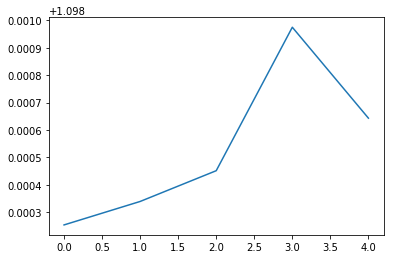

In [26]:
plt.plot(losses)

In [27]:
model.eval()

output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()

accuracy = d.sum().item()/d.size()[0]
print ('#========================================')
print ('Performance de note classifieur en test :')
print ('#========================================')
print ('Accuracy = tx de Bien Classe', round((100*accuracy),2),'%')
TMC=round((1-accuracy),2)
print('Taux de mal Classe:', round((TMC*100),2),'%')

#========================================
Performance de note classifieur en test :
#========================================
Accuracy = tx de Bien Classe 42.31 %
Taux de mal Classe: 58.0 %


In [28]:
# == Analyse : sur le critere d accuracy, avec un small dataset, le MLP fait moins bien que le hasard (50%)

In [ ]:
# == 3  leviers d amelioration pour redresser l accuracy :
# levier 1 = faire de la "vrai data augmentation", en generant des images avec un reseau GAN
# levier 2 = utiliser une modele de transfert learning (ie inception v3)
# levier 3 = levier 2 + un mlp surcouche + une validation croisee kfolds (hyper parametre : nb de couches (?))

In [29]:
# Affichage du temps d execution
print("Temps d execution : %s secondes ---" % round((time.time() - start_time),1))

Temps d execution : 111.8 secondes ---


In [30]:
# == Analyse : pour un GPU GTX1060M < 2 minutes, le temps de convergence est "nominal"